# AP HW6

## Behavioural Finance

#### Assume Barberis, Huang, and Santos economy where investor receives utility from consumption as well as recent financial gain or loss. Use these parameters:
$$
\delta = 0.99, \quad \gamma = 1, \quad \lambda = 2
$$

#### Consumption growth has lognormal distribution:
$$
\ln \tilde{g} = 0.02 + 0.02 \tilde{\varepsilon}
$$

#### where ε is standard normal random variable. Simulate probability distribution for consumption growth with (at least) 104 random draws from standard normal distribution.

#### With these parameters, risk-free rate is around 3% per year:
$$
R_f = \frac{e^{0.0198}}{0.99} = 1.0303 
$$
#### Define x as one plus dividend yield for market portfolio:
$$
x = \left(1 + \frac{P}{D}\right) \frac{D}{P} = 1 + \frac{D}{P}
$$
#### and define error term:
$$
e(x) = 0.99b_0 E[v(x\tilde{g})] + 0.99x - 1
$$
#### where utility from recent financial gain or loss is given by:
$$
v(R) = \begin{cases}R - 1.0303 & \text{for } R \geq 1.0303 \\
v(R) = 2(R - 1.0303) & \text{for } R < 1.0303\end{cases}
$$
#### Solve for e(x) = 0 to find equilibrium value of x, using bisection search:
1. Set x– = 1 and x+ = 1.1, and use simulated distribution of consumption growth to confirm that e(x–) < 0 and e(x+) > 0 ⇒ solution must lie between x– and x+
2. Set x0 = 0.5*(x– + x+) and use simulated distribution of consumption growth to calculate e(x0)
3. If |e(x0)| < 10–5, then you have converged to solution
4. Otherwise if e(x0) < 0, then solution lies between x0 and x+ ⇒ repeat from step 2 with x– = x0
5. Otherwise if e(x0) > 0, then solution lies between x– and x0 ⇒ repeat from step 2 with x+ = x0
#### Repeat for b0 in range from 0 to 10, in increments of 0.1 (or less).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## <span style="color:red">设置参数</span>

#### 
> delta 是折现因子。\
> b0_values 是一组 b0 参数的取值范围，用于衡量投资者对近期财务损益的关注程度。\
> Rf 表示无风险利率，假设为 3% 年化收益率。\
> mu 和 sigma 分别为消费增长的均值和波动率，假设消费增长服从对数正态分布。

In [ ]:
# define all parameters
delta = 0.99
b0_values = np.arange(0, 10.1, 0.1)# from 0 to 10, step is 0.1
Rf = 1.0303#  无风险利率
mu = 0.02#  消费增长均值
sigma = 0.02  # 消费增长的标准差

## <span style="color:red">模拟消费增长率的分布</span>

In [ ]:
np.random.seed(50)
num_samples = 10000

In [3]:
epsilon = np.random.normal(0, 1, num_samples)
log_g_tilde = mu + sigma * epsilon
g_tilde = np.exp(log_g_tilde)

In [4]:
# 定义损益效用函数 v(R)，用于模拟投资者对财务收益或损失的敏感度。
# 当 R >= Rf 时，v(R) = R - Rf，表示投资者的正常收益。
# 当 R < Rf 时，v(R) = 2 * (R - Rf)，表示投资者对损失的双倍敏感（损失厌恶）。
# 这种函数形式体现了行为金融学中的“损失厌恶”，即相较于收益，投资者对损失更敏感。
def v(R):
    return np.where(R >= Rf, R - Rf, 2 * (R - 1.0303))


# 定义函数 e(x)，用于计算给定 x 和 b0 下的期望收益差。
# expected_v = np.mean(v(x * g_tilde)) 计算在 x * g_tilde 下的 v(R) 的期望。
# delta * b0 * expected_v + delta * x - 1 是 e(x) 的计算公式，反映了投资者在 x 值下的期望收益与平衡条件的差距。
# 求解 e(x) = 0 可得市场均衡的 x 值，即市场组合的均衡价格。
def e_x(x, b0):
    expected_v = np.mean(v(x * g_tilde))
    return delta * b0 * expected_v + delta * x - 1

# Dichotomy solution e(x) = 0
# 使用二分法求解 e(x) = 0
# x_low 和 x_high 分别设定为初始区间的上下限（1.0 和 1.1）。
# x_mid 是区间的中点，通过 e_x(x_mid, b0) 计算 e(x) 的值。
# 当 e(x_mid) 接近 0 时，返回 x_mid 作为近似解，否则根据 e(x_mid) 的符号缩小区间范围。
# 最终返回使 e(x) 接近 0 的 x 值，即在给定 b0 下市场均衡时的 x 值。

def bisection_search(b0, tol=1e-5, max_iter=1000):
    x_low, x_high = 1.0, 1.1
    for _ in range(max_iter):
        x_mid = 0.5 * (x_low + x_high)
        e_mid = e_x(x_mid, b0)
        if abs(e_mid) < tol:
            return x_mid
        elif e_mid < 0:
            x_low = x_mid
        else:
            x_high = x_mid
    return x_mid

## <span style="color:red">计算价格-股利比率</span>
####
> x_star 是在给定 b0 值下通过二分法求得的市场均衡 x。\
> price_dividend_ratio = 1 / (x_star - 1) 计算价格-股利比率。价格-股利比率越高，意味着市场估值越高。\
> 将不同 b0 值下的价格-股利比率存储在 price_dividend_ratios 列表中。

#### Calculate price-dividend ratio for market portfolio:
$$
\frac{P}{D} = \frac{1}{x - 1}
$$
Plot price-dividend ratio (on vertical axis) vs b0.

In [5]:
price_dividend_ratios = []
for b0 in b0_values:
    x_star = bisection_search(b0)
    price_dividend_ratio = 1 / (x_star - 1)
    price_dividend_ratios.append(price_dividend_ratio)

## <span style="color:red">绘制价格-股利比率与 b0 的关系图</span>
####
> 横轴为 b0，纵轴为价格-股利比率。随着 b0 增大（投资者对短期财务盈亏的关注增加），价格-股利比率也会发生变化。该图展示了投资者关注短期财务变化对市场估值的影响。


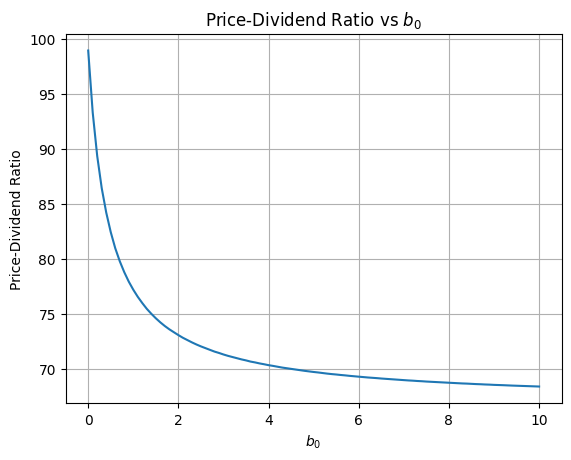

In [6]:
plt.plot(b0_values, price_dividend_ratios)
plt.xlabel('$b_0$')
plt.ylabel('Price-Dividend Ratio')
plt.title('Price-Dividend Ratio vs $b_0$')
plt.grid(True)
plt.show()

## <span style="color:red">计算期望市场收益和股权溢价</span>

#### Calculate expected market return:
$$
E\left(\tilde{R}_m\right) = E(x\tilde{g}) = x e^{0.0202}
$$
Plot equity premium (on vertical axis) vs b0.

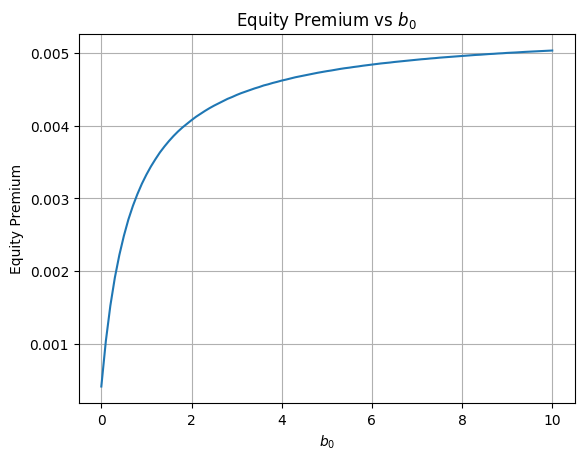

In [7]:
# calculate for expecation return
expected_market_returns = []
equity_premiums = []

for b0 in b0_values:
    x_star = bisection_search(b0)
    expected_market_return = x_star * np.exp(0.0202)# 计算市场组合的期望收益，假设消费增长率的对数均值为 0.0202。
    expected_market_returns.append(expected_market_return)
    equity_premium = expected_market_return - Rf# 计算股权溢价，即市场期望收益与无风险利率的差异。
    equity_premiums.append(equity_premium)

# 绘制股权溢价与 b0 的关系图
plt.plot(b0_values, equity_premiums)
plt.xlabel('$b_0$')
plt.ylabel('Equity Premium')
plt.title('Equity Premium vs $b_0$')
plt.grid(True)
plt.show()
# 随着 b0 增大，投资者对短期财务盈亏的关注增加，导致股权溢价上升。
# 股权溢价代表了投资者为了承担市场风险而期望的额外回报。

In [10]:
data = {
    'price-dividend ratio': price_dividend_ratios,
    'expected_market_returns': expected_market_returns,
    'equity_premiums': equity_premiums
}
df = pd.DataFrame(data)

df

,price-dividend ratio,expected_market_returns,equity_premiums
0,98.937198,1.030719,0.000419
1,93.302961,1.031342,0.001042
2,89.334787,1.031828,0.001528
3,86.413502,1.032214,0.001914
4,84.193217,1.032525,0.002225
...,...,...,...
96,68.423470,1.035318,0.005018
97,68.409186,1.035322,0.005022
98,68.394907,1.035325,0.005025
99,68.380634,1.035328,0.005028


#### Briefly describe (in words, without using mathematical equations or formulas) main characteristics of v(∙) as well as economic significance and implications of b0 and λ.
> v(∙) shows the investor's sensitivity to financial gains and losses, demonstrating loss aversion, which means losses have a greater emotional impact than equivalent gains. This makes investors more concerned about downside risk and more sensitive to potential losses.

> b0 represents how much weight an investor places on recent financial gains or losses. A higher value means the investor is more focused on short-term performance rather than solely on long-term wealth. A higher b0 will lead investors to demand a greater equity premium and can increase market volatility. During economic downturns or market declines, it may amplify price instability.

> λ represents the degree of loss aversion. A higher λ indicates that investors are more sensitive to losses compared to gains of the same magnitude. A higher λ will increase the demand for risk premiums, lowers equity prices, and amplify market volatility, especially during periods of economic uncertainty, as investors become more risk-averse.
